In [2]:
from ema_workbench import (Model, RealParameter,CategoricalParameter, IntegerParameter, TimeSeriesOutcome, ema_logging, perform_experiments)
# from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.outcomes import ArrayOutcome, ScalarOutcome
from ema_workbench.util import ema_exceptions
#from ema_workbench.analysis.plotting import lines
from ema_workbench.analysis import pairs_plotting
#feature scoring
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import prim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from pandas.core.indexing import convert_missing_indexer, convert_to_index_sliceable
import os 
import warnings
from math import floor
from ema_workbench.analysis import dimensional_stacking
from scipy import stats

# Change the current working directory
os.chdir('C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\src')
#print("Current working directory: {0}".format(os.getcwd()))

In [3]:
indir = "C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\outputs_rdm\\outputs_v6\\10pol_300\\"
outdir ='C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\outputs_rdm\\plots\\'

In [4]:
colnames= ['year','run','Conv_gas_price','Unconv_gas_price','Conv_oil_price','Unconv_oil_price',
'Conv_gas_ds_capex','Unconv_gas_ds_capex','Conv_oil_ds_capex','Unconv_oil_ds_capex',
'Conv_gas_opex','Unconv_gas_opex','Conv_oil_opex','Unconv_oil_opex',
'Conv_gas_domestic revenue','Unconv_gas_domestic revenue','Conv_oil_domestic revenue','Unconv_oil_domestic revenue',
'Conv_gas_export revenue','Unconv_gas_export revenue','Conv_oil_export revenue','Unconv_oil_export revenue',
'Conv_gas_production subsidy','Unconv_gas_production subsidy','Conv_oil_production subsidy','Unconv_oil_production subsidy',
'Conv_gas_import subsidy','Unconv_gas_import subsidy','Conv_oil_import subsidy','Unconv_oil_import subsidy',
'Conv_gas_royalties','Unconv_gas_royalties','Conv_oil_royalties','Unconv_oil_royalties',
'Conv_gas_export duties','Unconv_gas_export duties','Conv_oil_export duties','Unconv_oil_export duties',
'Conv_gas_trade balance','Unconv_gas_trade balance','Conv_oil_trade balance','Unconv_oil_trade balance',
'Conv_gas_us_capex','Unconv_gas_us_capex','Conv_oil_us_capex','Unconv_oil_us_capex',
'Conv_gas_starts','Unconv_gas_starts','Conv_oil_starts','Unconv_oil_starts',
'Conv_gas_discount_factor','Unconv_gas_discount_factor','Conv_oil_discount_factor','Unconv_oil_discount_factor']


In [167]:
outcomes = pd.read_csv(indir+"vm_outcomes_2.csv")
experiments = pd.read_csv(indir+"vm_experiments_2.csv")
tradebal= pd.read_csv(indir+"fiscal ts outcomes_2.csv",index_col = False,names = colnames, skiprows = 1 )
physbal = pd.read_csv(indir+"physical ts outcomes_2.csv" )

In [168]:
# print(tradebal["Unconv_gas_discount_factor"].head())
tradebal["Unconv_gas_tb_disc"]= tradebal["Unconv_gas_trade balance"]*tradebal["Unconv_gas_discount_factor"]
tradebal["Unconv_oil_tb_disc"]= tradebal["Unconv_oil_trade balance"]*tradebal["Unconv_oil_discount_factor"]

In [169]:
fbal = tradebal.groupby('run').sum()
fbal=fbal/383100000000*100

# pbal =  physbal.groupby('run').mean()
# print(pbal.head())

In [197]:
print(experiments.columns)

# data = pd.merge(outcomes, experiments)
# data = data.rename(columns= {'Unnamed: 0':'run'}).set_index('run')
# data = pd.merge(data,fbal, left_on = 'run',right_on= 'run')
# data= data.drop(['model'], axis=1)
# data.policy.astype(str)

# experiments= experiments.drop(['model','Unnamed: 0'], axis=1)
# experiments.policy =experiments.policy.astype(str)
# print(experiments.head())

Index(['conv_prod_decline_end_gas', 'conv_prod_decline_end_oil', 'discount',
       'gas_demand_decline_speed', 'gas_export_dem_end', 'gas_opex', 'm',
       'oil_demand_decline_speed', 'oil_export_dem_end', 'oil_opex', 'pes_gas',
       'pes_oil', 'rcp', 't_rate_e', 'unconv_prod_decline_end_gas',
       'unconv_prod_decline_end_oil', 'us_capex_gas', 'us_capex_oil',
       'well_life', 'public_ds_capex_share', 'profit_tax_rate',
       'share_covered', 'prod_subsidy_p_ratio', 'royalty_rate_gas',
       'duty_rate_gas', 'royalty_rate_oil', 'duty_rate_oil',
       'cons_wedge_end_gas', 'cons_wedge_end_oil', 'intl_wedge_end_gas',
       'intl_wedge_end_oil', 'a_gas_trans', 'a_gas_res', 'a_gas_ind',
       'a_oil_trans', 'a_oil_res', 'a_oil_ind', 'a_el_trans', 'a_el_res',
       'a_el_ind', 'gas_ex_cap_end', 'gas_ex_cap_increase', 'oil_ex_cap_end',
       'oil_ex_cap_increase', 'policy'],
      dtype='object')


In [131]:
data.columns

Index(['npv_gdp', 'npv_unsub_gdp', 'total_tb_gdp', 'total_ft_gdp',
       'wells_total', 'gdp_npv_conv_gas', 'gdp_npv_conv_oil',
       'gdp_npv_unconv_gas', 'gdp_npv_unconv_oil', 'gdp_ft_conv_gas',
       ...
       'Conv_gas_starts', 'Unconv_gas_starts', 'Conv_oil_starts',
       'Unconv_oil_starts', 'Conv_gas_discount_factor',
       'Unconv_gas_discount_factor', 'Conv_oil_discount_factor',
       'Unconv_oil_discount_factor', 'Unconv_gas_tb_disc',
       'Unconv_oil_tb_disc'],
      dtype='object', length=114)

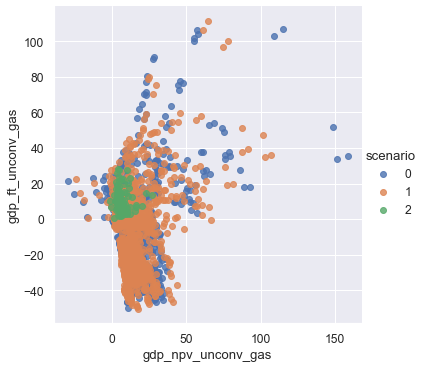

In [132]:
#define scenario
#&(data['t_rate_gas'] > .003)&

data.scenario = 0 
data.loc[(data['rcp'] =='CURR')&(data['wells_total'] >=10000), 'scenario'] =0
data.loc[(data['rcp'] =='1.5')&(data['wells_total'] >=10000), 'scenario'] =1
data.loc[(data['rcp'] =='1.5')&(data['wells_total'] <10000), 'scenario'] = 2

plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

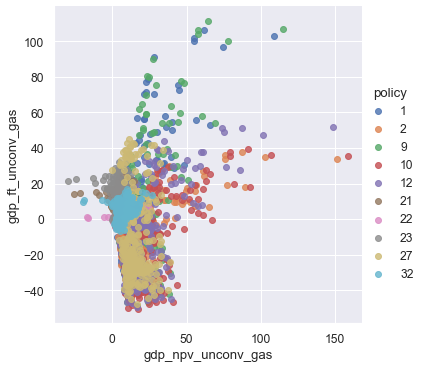

In [133]:
data.scenario = 0 


plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='policy', legend=True)
plt.show()

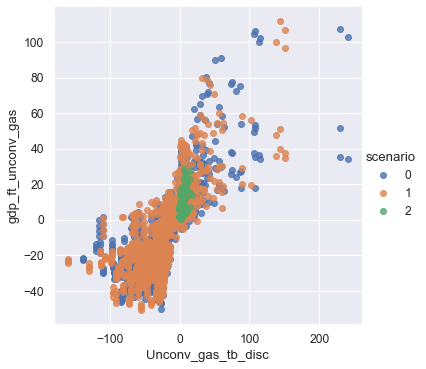

In [134]:
data.scenario = 0 
data.loc[(data['rcp'] =='CURR')&(data['wells_total'] >=10000), 'scenario'] =0
data.loc[(data['rcp'] =='1.5')&(data['wells_total'] >=10000), 'scenario'] =1
data.loc[(data['rcp'] =='1.5')&(data['wells_total'] <10000), 'scenario'] = 2

plot = sns.lmplot(x="Unconv_gas_tb_disc", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

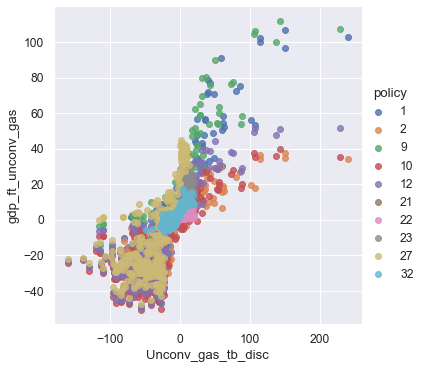

In [135]:
plot = sns.lmplot(x="Unconv_gas_tb_disc", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='policy', legend=True)
plt.show()

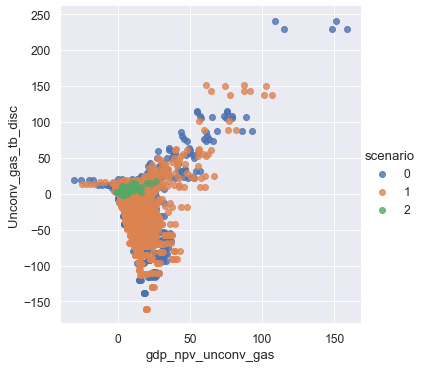

In [136]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_tb_disc", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

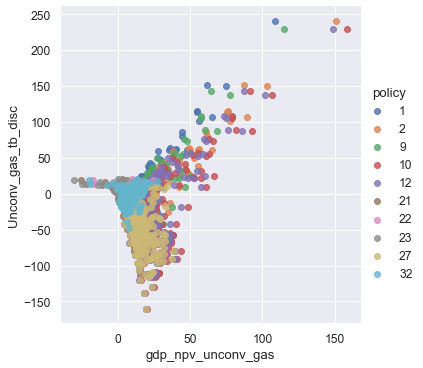

In [137]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_tb_disc", data=data, fit_reg=False, hue='policy', legend=True)
plt.show()

In [138]:
#define success

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_tb_disc'] >0), 'success3'] ="Positive Impacts"
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_tb_disc'] <0), 'success3'] ="Negative Impacts"

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0), 'success_ft'] =1
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0), 'success_ft'] =0

data.loc[(data['Unconv_gas_tb_disc'] >0)&(data['gdp_npv_unconv_gas'] >0), 'success_tb'] =1
data.loc[(data['Unconv_gas_tb_disc'] <0)|(data['gdp_npv_unconv_gas'] <0), 'success_tb'] =0

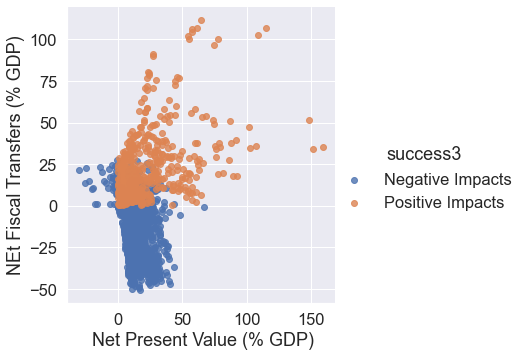

In [139]:
#add legend and axis labels here
sns.set(font_scale = 1.5)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='success3', legend=True)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="NEt Fiscal Transfers (% GDP)")

plt.show()

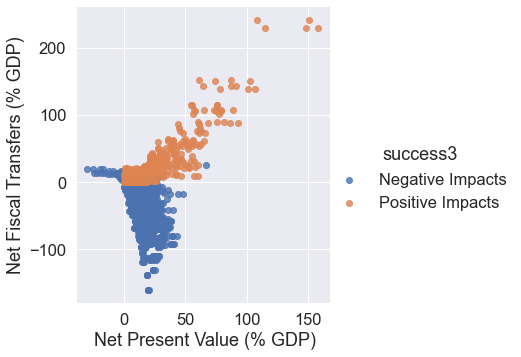

In [140]:
#add legend and axis labels here
sns.set(font_scale = 1.5)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_tb_disc", data=data, fit_reg=False, hue='success3', legend=True)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="Net Fiscal Transfers (% GDP)")

plt.show()

In [141]:
pd.crosstab(data['success_ft'],data['success3'])


success3,Negative Impacts,Positive Impacts
success_ft,,
0.0,1538,0
1.0,655,807


In [142]:
#note this is wrong below
pd.crosstab(data['scenario'],data['success3'])
# data.loc[(data['Unconv_gas_tb_disc'] >0)&(data['gdp_npv_unconv_gas'] >0)

success3,Negative Impacts,Positive Impacts
scenario,,
0,1087,413
1,1094,327
2,12,67


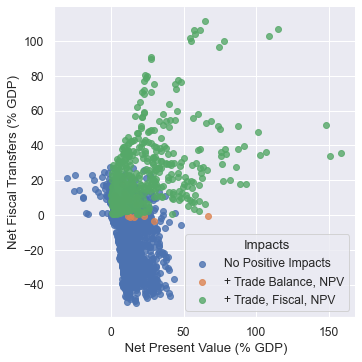

In [143]:
#graph for executive Summary
data['three_level'] =0
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_tb_disc'] <0), 'three_level'] = 0
data.loc[(data['Unconv_gas_trade balance'] >0)&(data['gdp_npv_unconv_gas'] >0), 'three_level'] =1
data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_tb_disc'] >0), 'three_level'] =2

sns.set(font_scale = 1.1)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="Net Fiscal Transfers (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts','+ Trade Balance, NPV', '+ Trade, Fiscal, NPV']
# 
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

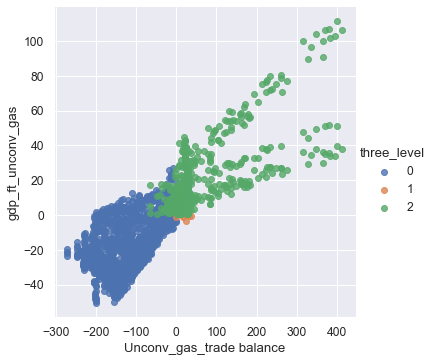

In [144]:
#do trade and fiscal impact on the axis - then color by npv

# data["gdp_npv_unconv_gas"]
plot = sns.lmplot(x="Unconv_gas_trade balance", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='three_level', legend=True)
plt.show()

# 

In [145]:
data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_tb_disc'] >0), 'success3_val'] = 1
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_tb_disc'] <0), 'success3_val'] = 0

data.loc[(data['rcp'] =='CURR')&(data['wells_total'] >=10000), 'scenario'] =0
data.loc[(data['rcp'] =='1.5')&(data['wells_total'] >=10000), 'scenario'] =1
data.loc[(data['rcp'] =='1.5')&(data['wells_total'] <10000), 'scenario'] = 2


print(pd.Series.corr(data['scenario'],data['success3_val']))


0.04958561800906921


In [146]:
#negative correlation between
print(pd.Series.corr(data['wells_total'],data['success3_val']))

-0.1156221113747111


In [147]:
data.loc[(data['wells_total'] <10000), 'well_high_low'] = 0
data.loc[(data['wells_total'] >=10000), 'well_high_low'] = 1
pd.crosstab(data['well_high_low'],data['success3_val'])

success3_val,0.0,1.0
well_high_low,,
0.0,26,144
1.0,2167,663


In [148]:
pd.crosstab(data['scenario'],data['success3_val'])

success3_val,0.0,1.0
scenario,,
0,1087,413
1,1094,327
2,12,67


In [149]:
# pd.crosstab(data['scenario'],data['success3'])

from scipy import stats
crosstab = pd.crosstab(data['scenario'],data['success3_val'])
stats.chi2_contingency(crosstab)

(145.96072912587806,
 2.0185075725371895e-32,
 2,
 array([[1096.5  ,  403.5  ],
        [1038.751,  382.249],
        [  57.749,   21.251]]))

In [150]:
# pd.crosstab(data['scenario'],data['success_ft'])

crosstab = pd.crosstab(data['scenario'],data['success_ft'])
stats.chi2_contingency(crosstab)

(79.97670949517607,
 4.298116598088579e-18,
 2,
 array([[769.        , 731.        ],
        [728.49933333, 692.50066667],
        [ 40.50066667,  38.49933333]]))

In [151]:
pd.crosstab(data['scenario'],data['success_ft'])


success_ft,0.0,1.0
scenario,,
0,766,734
1,770,651
2,2,77


In [152]:
pd.crosstab(data['scenario'],data['success_tb'])

success_tb,0.0,1.0
scenario,,
0,1082,418
1,1088,333
2,12,67


In [153]:
crosstab = pd.crosstab(data['scenario'],data['success_tb'])
stats.chi2_contingency(crosstab)

(142.69903077555264,
 1.0310961864809471e-31,
 2,
 array([[1091.        ,  409.        ],
        [1033.54066667,  387.45933333],
        [  57.45933333,   21.54066667]]))

In [154]:
# crosstab = pd.crosstab(data['scenario'],data.loc[data['wells_total']<=12000,'wells_total'])
# stats.chi2_contingency(crosstab)

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


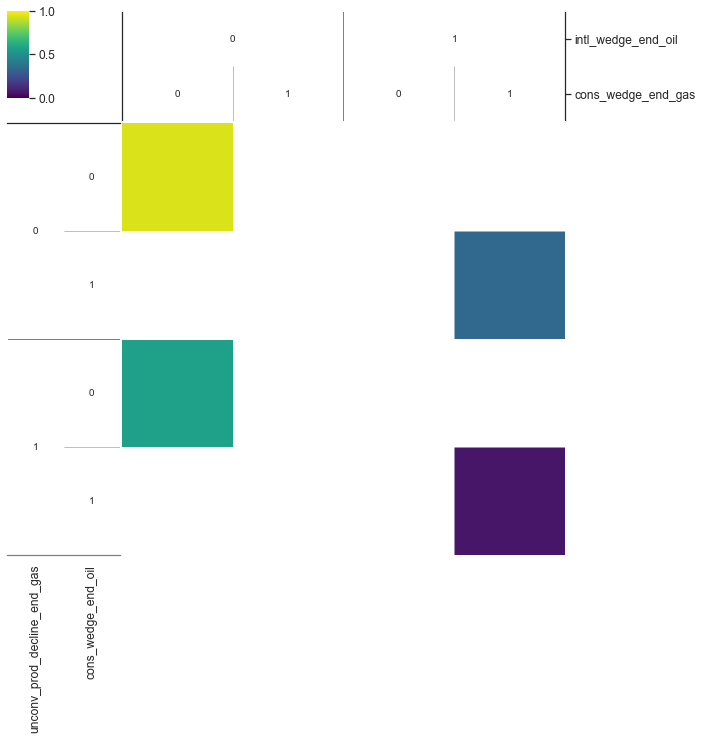

In [172]:
%matplotlib inline

x = experiments
# y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_oil'] >0)&(data['Unconv_oil_tb_disc'] >0)
y = (data['npv_gdp'] >0)&(data['total_tb_gdp'] >0)&(data['total_ft_gdp'] >0)

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=2, categories = True, labels = True)
plt.show()

In [ ]:
#overall results from total NPV, Total FT, and Total TB

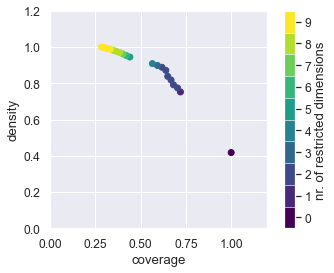

In [173]:
y = (data['npv_gdp'] >0)&(data['total_tb_gdp'] >0)&(data['total_ft_gdp'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

In [193]:
# %matplotlib notebook
box_overall.inspect(i=7, style='table')
# box_overall.inspect(i=7, style='graph')

coverage    0.618022
density     0.888761
id                 7
mass        0.290667
mean        0.888761
res_dim            2
Name: 7, dtype: object

                                box 7            \
                                  min       max   
cons_wedge_end_gas           0.800000  2.150000   
unconv_prod_decline_end_gas  0.000212  0.109096   

                                                              
                                                   qp values  
cons_wedge_end_gas           [-1.0, 1.2658396764217467e-124]  
unconv_prod_decline_end_gas    [-1.0, 3.255272437988716e-24]  



In [ ]:
#why are any of these negative individually

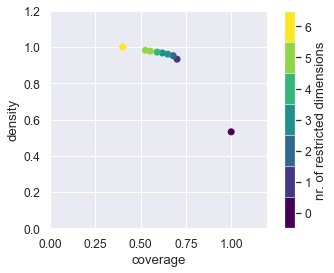

In [191]:
y = (data['total_tb_gdp'] >-10)
prim_alg = prim.Prim(x, y, threshold=0.05)
box_tb = prim_alg.find_box() 

box_tb.show_tradeoff()
plt.show()

coverage    0.680025
density     0.952632
id                 2
mass            0.38
mean        0.952632
res_dim            2
Name: 2, dtype: object

                                box 2            \
                                  min       max   
cons_wedge_end_gas           0.800000  2.150000   
unconv_prod_decline_end_gas  0.000212  0.142538   

                                                              
                                                   qp values  
cons_wedge_end_gas           [-1.0, 4.4528499646926184e-210]  
unconv_prod_decline_end_gas    [-1.0, 0.0038803173723754108]  



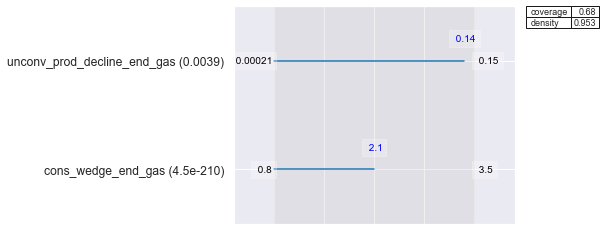

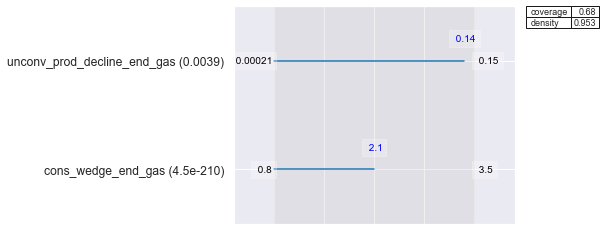

In [195]:
%matplotlib inline
box_tb.inspect(i=2, style='table')
box_tb.inspect(i=2, style='graph')

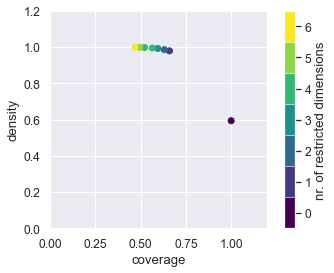

In [185]:
y = (data['total_ft_gdp'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box_ft = prim_alg.find_box() 

box_ft.show_tradeoff()
plt.show()

coverage    0.659742
density     0.979167
id                 1
mass             0.4
mean        0.979167
res_dim            1
Name: 1, dtype: object

                   box 1                                      
                     min   max                       qp values
cons_wedge_end_gas   0.8  2.15  [-1.0, 6.728873103709481e-225]



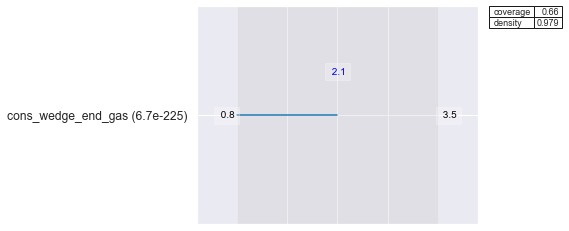

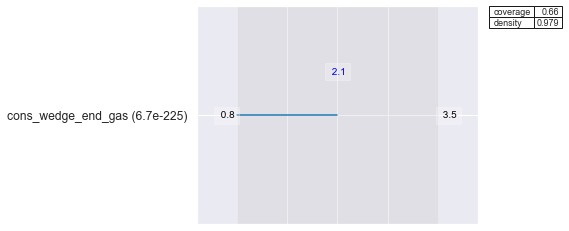

In [188]:
%matplotlib inline
box_ft.inspect(i=1, style='table')
box_ft.inspect(i=1, style='graph')

In [48]:
#highly supported - high subsidy rate high subsidy shar
data.loc[(data['public_ds_capex_share'] >data["public_ds_capex_share"].quantile(.5)), 'support'] ="High"
data.loc[(data['public_ds_capex_share'] <=data["public_ds_capex_share"].quantile(.5)), 'support'] ="Low"

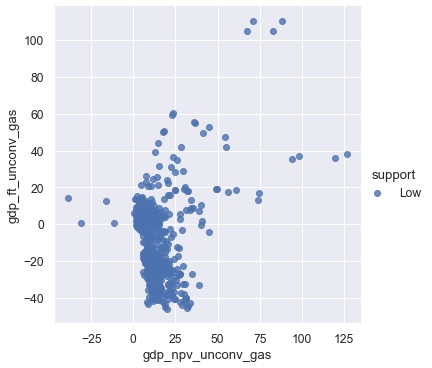

In [49]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

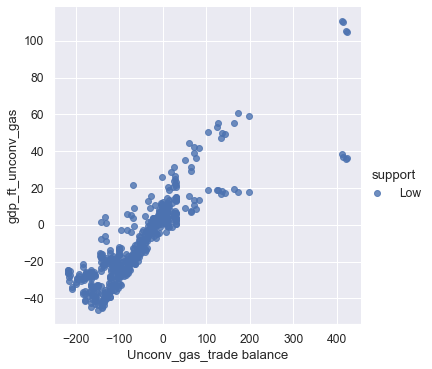

In [50]:
plot = sns.lmplot(x="Unconv_gas_trade balance", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

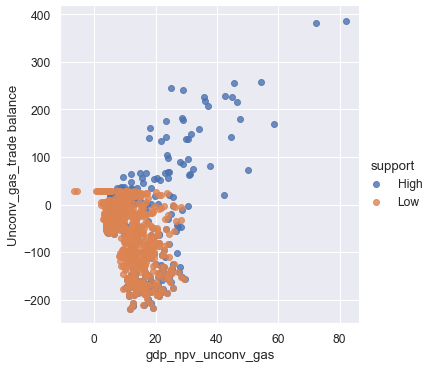

In [68]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

In [ ]:
# diverging_colors = sns.color_palette("RdBu", 3)

# plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue="Unconv_gas_trade balance", legend=True)
# plt.show()

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# z =data['gdp_npv_unconv_gas']
# y =data['gdp_ft_unconv_gas']
# x =data['Unconv_gas_trade balance']

# c = (data['success3']>0)
# ax.scatter(x, y, z, c=c, marker='o')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


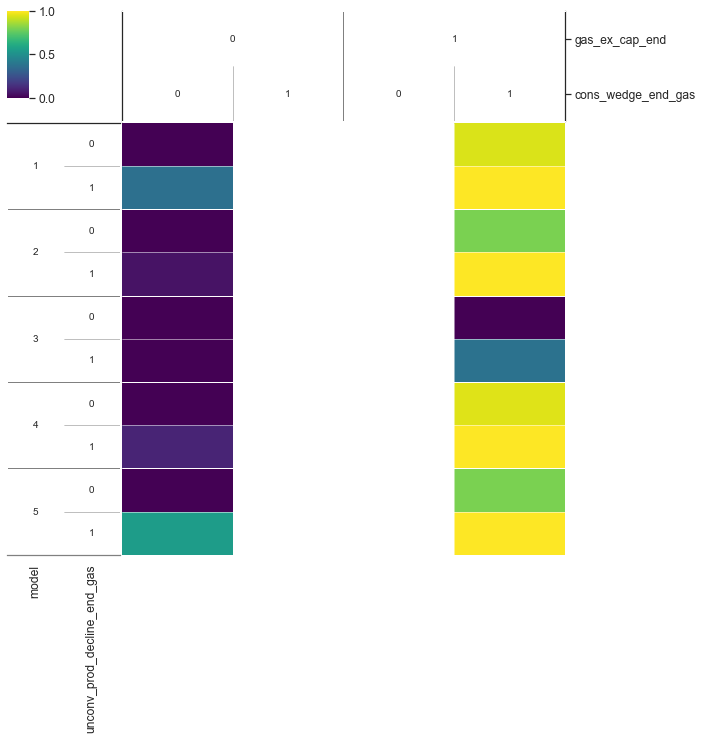

In [103]:
%matplotlib inline
x = experiments
y = (data['gdp_ft_unconv_gas'] <0)

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=2)
plt.show()

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


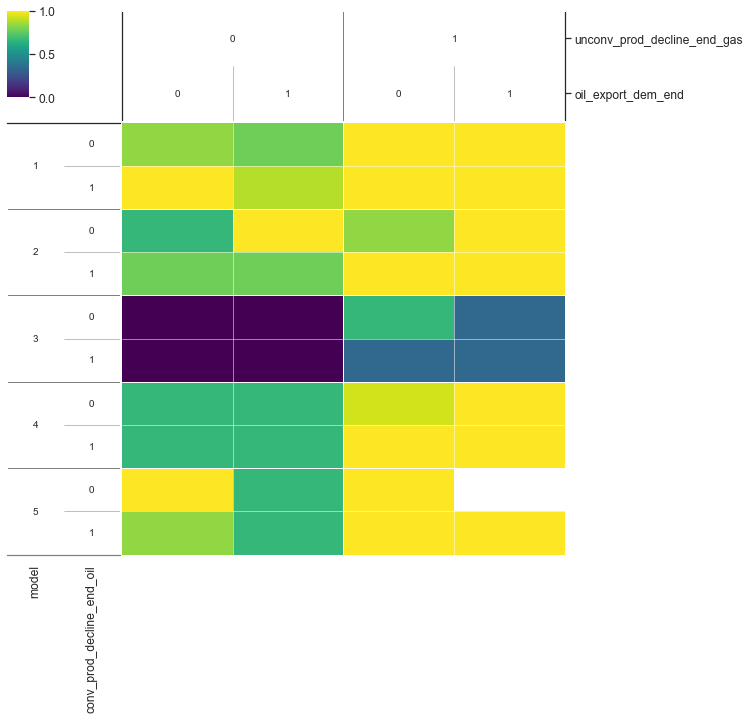

In [102]:
%matplotlib inline
x = experiments
y = (data['Unconv_gas_tb_disc'] <0)

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=2)
plt.show()

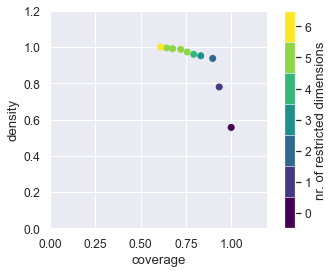

In [104]:
y =(data['gdp_ft_unconv_gas'] <0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box2 = prim_alg.find_box() 

box2.show_tradeoff()
plt.show()

coverage    0.793413
density     0.960145
id                 4
mass            0.46
mean        0.960145
res_dim            4
Name: 4, dtype: object

                                                 box 4  \
                                                   min   
gas_demand_decline_speed                           3.0   
cons_wedge_end_gas                                2.15   
model                      {REMIND, MESSAGE, WB, GCAM}   
conv_prod_decline_end_oil                       0.0073   

                                                        \
                                                   max   
gas_demand_decline_speed                          28.5   
cons_wedge_end_gas                                 3.5   
model                      {REMIND, MESSAGE, WB, GCAM}   
conv_prod_decline_end_oil                     0.119922   

                                                           
                                                qp values  
gas_demand_decline_speed      [-

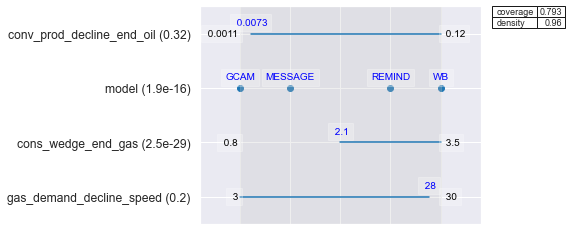

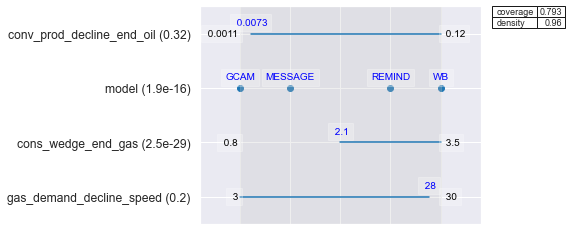

In [105]:
%matplotlib inline
box2.inspect(i=4, style='table')
box2.inspect(i=4, style='graph')

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


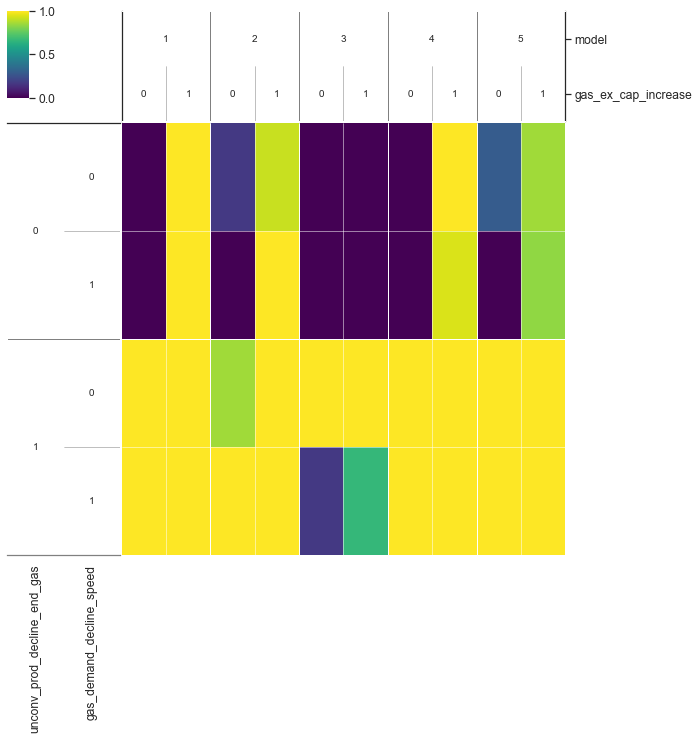

In [57]:
%matplotlib inline
x = experiments
y = (data['Unconv_gas_trade balance'] <0)

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=2)
plt.show()

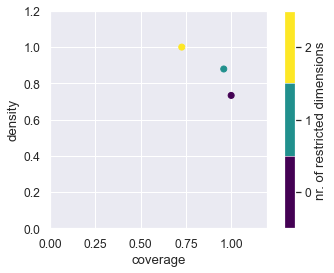

In [60]:
y = (data['Unconv_gas_tb_disc'] <0)
prim_alg = prim.Prim(x, y, threshold=0.005)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage    0.727273
density          1.0
id                 2
mass        0.533333
mean             1.0
res_dim            2
Name: 2, dtype: object

                                          box 2                               \
                                            min                          max   
model               {REMIND, MESSAGE, WB, GCAM}  {REMIND, MESSAGE, WB, GCAM}   
cons_wedge_end_gas                         2.15                          3.5   

                                                   
                                        qp values  
model                [3.92777737267681e-24, -1.0]  
cons_wedge_end_gas  [1.267034229047555e-18, -1.0]  



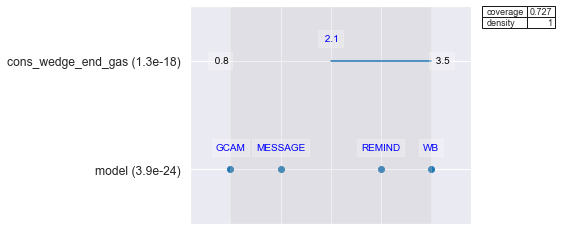

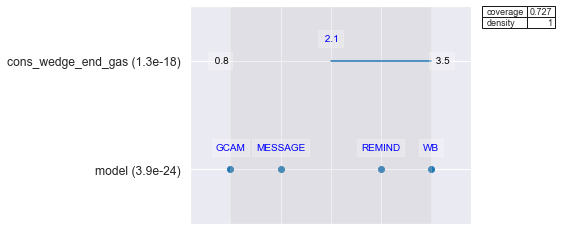

In [62]:
%matplotlib inline
box6.inspect(i=2, style='table')
box6.inspect(i=2, style='graph')

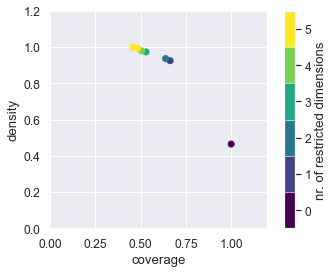

In [63]:
y = (data['gdp_npv_unconv_gas'] <10)
prim_alg = prim.Prim(x, y, threshold=0.15)
box4 = prim_alg.find_box() 

box4.show_tradeoff()
plt.show()

coverage    0.530466
density     0.973684
id                 3
mass        0.253333
mean        0.973684
res_dim            3
Name: 3, dtype: object

                                          box 3                               \
                                            min                          max   
cons_wedge_end_gas                          0.8                         2.15   
model               {REMIND, MESSAGE, WB, GCAM}  {REMIND, MESSAGE, WB, GCAM}   
conv_start_gr_gas                      0.039636                     0.799913   

                                                    
                                         qp values  
cons_wedge_end_gas  [-1.0, 1.6179436824233126e-37]  
model                 [0.033593768871793904, -1.0]  
conv_start_gr_gas       [0.4832112303027084, -1.0]  



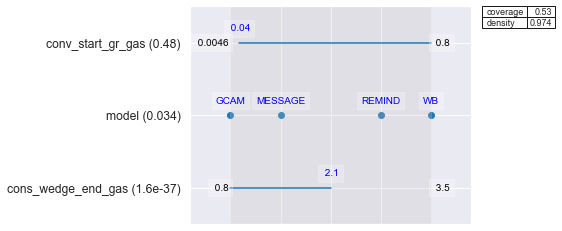

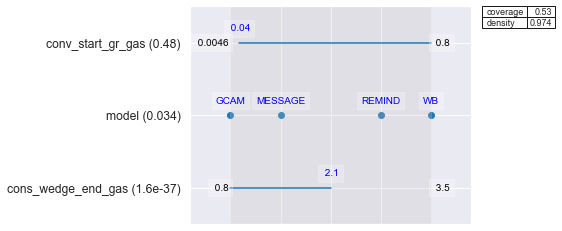

In [64]:
%matplotlib inline
box4.inspect(i=3, style='table')
box4.inspect(i=3, style='graph')

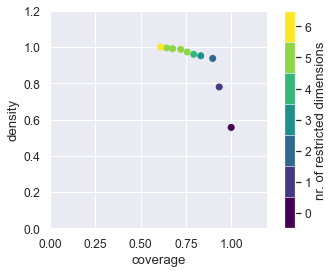

In [65]:
y = (data['gdp_ft_unconv_gas'] <0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box5 = prim_alg.find_box() 

box5.show_tradeoff()
plt.show()

coverage    0.898204
density       0.9375
id                 2
mass        0.533333
mean          0.9375
res_dim            2
Name: 2, dtype: object

                                          box 2                               \
                                            min                          max   
cons_wedge_end_gas                         2.15                          3.5   
model               {REMIND, MESSAGE, WB, GCAM}  {REMIND, MESSAGE, WB, GCAM}   

                                                    
                                         qp values  
cons_wedge_end_gas   [7.062416910344669e-31, -1.0]  
model               [1.1092126106652479e-14, -1.0]  



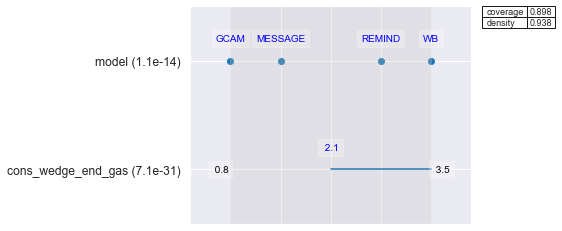

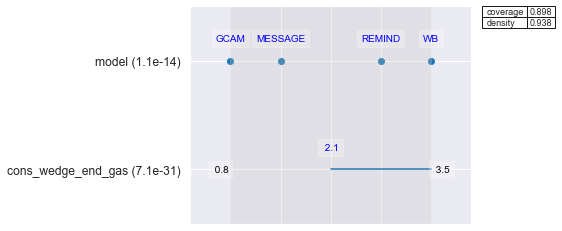

In [66]:
%matplotlib inline
box5.inspect(i=2, style='table')
box5.inspect(i=2, style='graph')

In [86]:
from scipy import stats
crosstab = pd.crosstab(data['success3'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support           High  Low
success3                   
Negative Impacts   279  588
Positive Impacts   121  212


(1.6880202001309268,
 0.19386215608149895,
 1,
 array([[289., 578.],
        [111., 222.]]))

In [87]:
crosstab = pd.crosstab(data['success_tb'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support     High  Low
success_tb           
0.0          279  588
1.0          121  212


(1.6880202001309268,
 0.19386215608149895,
 1,
 array([[289., 578.],
        [111., 222.]]))

In [88]:
crosstab = pd.crosstab(data['success_ft'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support     High  Low
success_ft           
0.0          196  342
1.0          204  458


(3.9627298150248764,
 0.04651820780299377,
 1,
 array([[179.33333333, 358.66666667],
        [220.66666667, 441.33333333]]))

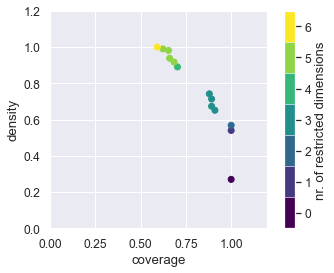

In [89]:
x = experiments
y = (data['Unconv_gas_trade balance'] <-100)
prim_alg = prim.Prim(x, y, threshold=0.15)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage    0.654321
density     0.981481
id                10
mass            0.18
mean        0.981481
res_dim            5
Name: 10, dtype: object

                                                  box 10  \
                                                     min   
discount                                        0.030148   
cons_wedge_end_gas                                  2.25   
unconv_prod_decline_end_gas                     0.035015   
profit_tax_rate                                    0.225   
model                        {REMIND, GCAM, WB, MESSAGE}   

                                                          \
                                                     max   
discount                                        0.087115   
cons_wedge_end_gas                                   3.5   
unconv_prod_decline_end_gas                     0.119577   
profit_tax_rate                                      0.3   
model                        {REMIND, GCAM, WB, MESSAGE}   

       

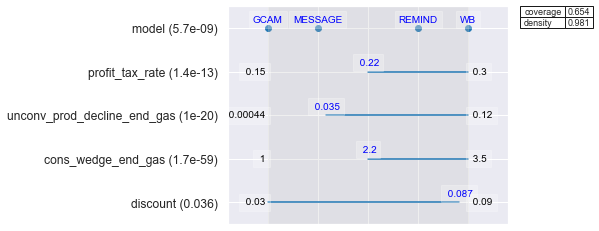

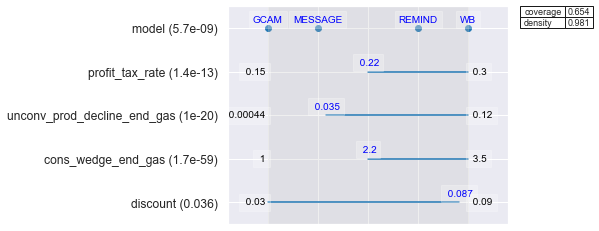

In [90]:
%matplotlib inline
box6.inspect(i=10, style='table')
box6.inspect(i=10, style='graph')

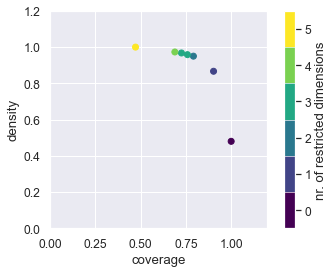

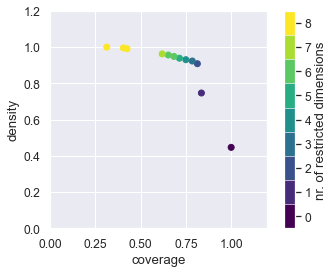

In [94]:
x = experiments
y = (data['gdp_ft_unconv_gas'] <0)


prim_alg = prim.Prim(x, y, threshold=0.15)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage    0.404851
density     0.995413
id                10
mass        0.181667
mean        0.995413
res_dim            8
Name: 10, dtype: object

                                                box 10  \
                                                   min   
pes_oil                                       0.600251   
cons_wedge_end_gas                                2.25   
model                      {REMIND, GCAM, WB, MESSAGE}   
profit_tax_rate                                  0.225   
discount                                      0.037149   
foreign_capex_share                           0.034689   
gas_export_dem_end                            0.056107   
conv_prod_decline_end_oil                       0.0068   

                                                        \
                                                   max   
pes_oil                                        1.35116   
cons_wedge_end_gas                                 3.5   
model                      {REMIND, 

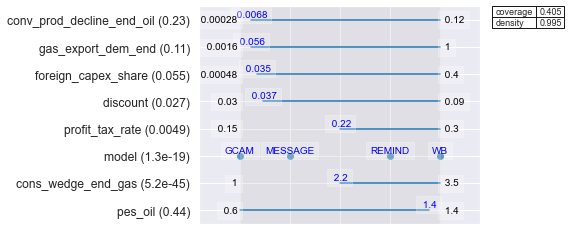

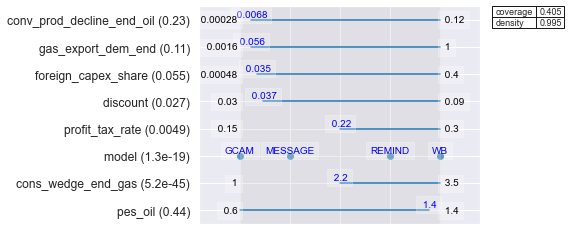

In [96]:
%matplotlib inline
box6.inspect(i=10, style='table')
box6.inspect(i=10, style='graph')

# subset

In [ ]:
param_names =['rcp', 'T_bond_rate','arg_sov_risk','opp_cost_own_finance','share_own_capital','opp_cost_debt',
              'pes_oil','pes_gas','t_rate_gas','t_rate_oil','t_rate_e','us_capex_gas','us_capex_oil',
              'm','oil_opex','gas_opex','share_covered','prod_subsidy_p_ratio','royalty_rate_gas',
              'duty_rate_gas','royalty_rate_oil','duty_rate_oil','price_threshold_gas','price_threshold_oil',
              'price_floor_gas','price_floor_oil','conv_start_gr_gas','conv_start_gr_oil',
              'conv_prod_decline_end_gas','conv_prod_decline_end_oil','unconv_prod_decline_end_gas',
              'unconv_prod_decline_end_oil','cons_wedge_end_gas','cons_wedge_end_oil','intl_wedge_end_gas',
              'intl_wedge_end_oil','a_gas_trans','a_gas_res','a_gas_ind','a_oil_trans','a_oil_res',
              'a_oil_ind','a_el_trans','a_el_res','a_el_ind','well_life','gas_ex_cap_end',
              'gas_ex_cap_increase','oil_ex_cap_end','oil_ex_cap_increase',
              'gas_export_dem_end','oil_export_dem_end',
              'gas_demand_decline_speed','oil_demand_decline_speed','public_ds_capex_share']


In [ ]:
d = data[((data['model']=="WB")&
#     (data['unconv_prod_decline_end_gas']<.05)]
    (data['t_rate_gas']<.03))]

In [ ]:
data['subset'] =0
data.loc[(data['m']<30000)&  
         (data['t_rate_gas']<.03),'subset'] = 1
#          (data['unconv_prod_decline_end_gas']<.05),'subset'] = 1

In [ ]:
d.describe()

In [ ]:
x = d[param_names]

In [ ]:
# crosstab = pd.crosstab(d['three_level'],d['support'])
# stats.chi2_contingency(crosstab)

In [ ]:
# plot = sns.lmplot(x="gdp_ft_unconv_gas", y="gdp_npv_unconv_gas", data=d, fit_reg=False, hue='success3', legend=True)
# plt.show()

In [ ]:
# #data_cut.describe()
# pd.crosstab(d['subset'],d['three_level'])

In [ ]:
#graph for executive Summary

d.loc[(d['gdp_npv_unconv_gas'] <0)|(d['gdp_ft_unconv_gas'] <0)|(d['Unconv_gas_trade balance'] <0), 'three_level'] = 0
d.loc[(d['Unconv_gas_trade balance'] >0)&(d['gdp_npv_unconv_gas'] >0), 'three_level'] =1
d.loc[(d['gdp_npv_unconv_gas'] >0)&(d['gdp_ft_unconv_gas'] >0)&(d['Unconv_gas_trade balance'] >0), 'three_level'] =2

sns.set(font_scale = 1.1)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=d, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="Net Fiscal Transfers (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts', '+ Trade Balance, NPV','+ Trade, Fiscal, NPV']
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
sns.set(font_scale = 1.1)
d.loc[(d['gdp_npv_unconv_gas'] <0)|(d['gdp_ft_unconv_gas'] <0)|(d['Unconv_gas_trade balance'] <0), 'three_level'] = 0
d.loc[(d['gdp_ft_unconv_gas'] >0)&(d['gdp_npv_unconv_gas'] >0), 'three_level'] =1
d.loc[(d['gdp_npv_unconv_gas'] >0)&(d['gdp_ft_unconv_gas'] >0)&(d['Unconv_gas_trade balance'] >0), 'three_level'] =2

plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=d, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="Net Trade Balance (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts', '+ Fiscal Transfers, NPV','+ Trade, Fiscal, NPV']
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# summary = data.loc[(data['subset'] ==1)&(data['Unconv_gas_trade balance'] <-50)]
# # summary.to_csv(outdir+"summary_neg_tb.csv")

In [ ]:
pd.crosstab(d['scenario'],d['success_tb'])
#1839 #588 #32%

In [ ]:
pd.crosstab(d['scenario'],d['success_ft'])
#1839 #303 #16%

In [ ]:
d.loc[(d['wells_total']>10000), 'wells_high'] = 1
d.loc[(d['wells_total']<=10000), 'wells_high'] = 0

data.loc[(data['wells_total']>10000), 'wells_high1'] = 1
data.loc[(data['wells_total']<=10000), 'wells_high1'] = 0


d['wells_high'].describe()
pd.crosstab(d['scenario'],d['wells_high'])

In [ ]:
pd.crosstab(d['scenario'],d['success3'])
#106 #5.7%

In [ ]:
pd.crosstab(d['success3'],d['wells_high'])

In [ ]:
crosstab = pd.crosstab(d['success3'],d['wells_high'])
print(crosstab)
stats.chi2_contingency(crosstab)

In [ ]:
crosstab = pd.crosstab(data['success3'],data['wells_high1'])
print(crosstab)
stats.chi2_contingency(crosstab)

In [ ]:
# pd.crosstab(data['scenario'],data['success3'])

crosstab = pd.crosstab(d['success3'],d['scenario'])
stats.chi2_contingency(crosstab)

In [ ]:
pd.crosstab(d['success3'],d['support'])

In [ ]:
crosstab = pd.crosstab(d['success3'],d['support'])
stats.chi2_contingency(crosstab)

In [ ]:
outcomes = pd.read_csv(indir+"vm_outcomes_2.csv")
experiments = pd.read_csv(indir+"vm_experiments_2.csv")
tradebal= pd.read_csv(indir+"fiscal ts outcomes_2.csv",index_col = False,names = colnames, skiprows = 1 )
physbal = pd.read_csv(indir+"physical ts outcomes_2.csv" )

In [ ]:
y =d['gdp_ft_unconv_gas'] >0
prim_alg = prim.Prim(x, y, threshold=0.1)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

In [ ]:
%matplotlib inline
box1.inspect(i=30, style='table')
box1.inspect(i=30, style='graph')

In [ ]:
%matplotlib inline

y = (d['gdp_ft_unconv_gas'] >0)
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=2)
plt.show()